In [2]:
!git clone https://github.com/daniarnaizg/text-detector-ocr.git

Cloning into 'text-detector-ocr'...
remote: Counting objects: 71, done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 71 (delta 0), reused 2 (delta 0), pack-reused 68
Unpacking objects: 100% (71/71), done.
Checking out files: 100% (21/21), done.


In [3]:
!ls text-detector-ocr/Resources/datasets

cifar10-png.zip  MSRA-TD500.zip


In [0]:
from IPython.display import clear_output

In [0]:
# Get CHAR74K dataset
!wget http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/EnglishImg.tgz;
!tar -xzvf EnglishImg.tgz
clear_output()

In [0]:
# Get CIFAR10 dataset (http://pjreddie.com/media/files/cifar.tgz)
!unzip text-detector-ocr/Resources/datasets/cifar10-png.zip
clear_output()

In [7]:
!ls cifar10-png

test  train


In [8]:
!ls English/Img

BadImag  GoodImg


In [0]:
# Creation of the folders for the different classes
!mkdir dataset
!mkdir dataset/text
!mkdir dataset/notext

In [0]:
'''
All the images are moved to a folder depending on its class.
'''
import os

text_paths = ['English/Img/GoodImg/Bmp', 'English/Img/BadImag/Bmp']
notext_paths = ['cifar10-png/train', 'cifar10-png/test']

text_dest = 'dataset/text'
notext_dest = 'dataset/notext'

for path in text_paths:  
  text_folders = os.listdir(path)
  for folder in text_folders:
    folder_path = path + '/' + folder
    files = os.listdir(folder_path)
    for file in files:
      os.rename(folder_path + '/' + file, text_dest + '/' + file)

for path in notext_paths:
  files = os.listdir(path)
  for file in files:
    os.rename(path + '/' + file, notext_dest + '/' + file)

In [11]:
!ls dataset/

notext	text




---



In [12]:
import matplotlib.pyplot as plt

import numpy as np
import glob
import cv2
import os

from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D
from keras.layers import Flatten, Lambda, BatchNormalization
from keras.models import Sequential
from keras.layers.advanced_activations import LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [0]:
'''Config of the model'''
EPOCHS = 10     # Number of training epochs
INIT_LR = 1e-3  # Initial Learning rate
BS = 32         # Batch size

data = []
labels = []

In [0]:
'''
Extraction of the data and label of every image.
'''
text_dir = glob.glob('dataset/text/*.png')
notext_dir = glob.glob('dataset/notext/*.png')

for imagePath in text_dir:
  image = cv2.imread(imagePath)
  image = cv2.resize(image, (28, 28))
  image = img_to_array(image)
  data.append(image)
  labels.append(0) # 0 is text
  
for imagePath in notext_dir:
  image = cv2.imread(imagePath)
  image = cv2.resize(image, (28, 28))
  image = img_to_array(image)
  data.append(image)
  labels.append(1) # 1 is notext

In [0]:
# scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

In [0]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data,
	labels, test_size=0.25, random_state=42)

In [17]:
trainX.shape

(29955, 28, 28, 3)

In [18]:
trainY.shape

(29955,)

In [0]:
# convert the labels from integers to vectors
trainY = to_categorical(trainY, num_classes=2)
testY = to_categorical(testY, num_classes=2)

In [20]:
trainY.shape

(29955, 2)

In [0]:
# initialize the model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

optimizer = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [25]:
!ls text-detector-ocr/Models

char74k_OCR.h5	emnist-model-1.h5  text-notext.h5


In [0]:
model_path = 'text-detector-ocr/Models/text-notext.h5'

In [0]:
# Load the model so it isn´t necessary to train it everytime
model.load_weights(model_path)

In [28]:
# train the network
# model.fit(trainX, trainY, batch_size=BS, validation_data=(testX, testY), epochs=EPOCHS, verbose=1)
# model.save(model_path)

score = model.evaluate(testX, testY, verbose=1)

print('Test loss: ' + str(score[0]))
print('Test accuracy: ' + str(score[1]))

9985/9985 [==============================] - 5s 498us/step
Test loss: 0.03368848963828701
Test accuracy: 0.9897846770155233


In [0]:
# from google.colab import files
# files.download(model_path)



---



In [0]:
# EVALUACION

# load the image
image = cv2.imread('dataset/notext/4095_ship.png')
orig = image.copy()

# pre-process the image for classification
image = cv2.resize(image, (28, 28))
image = image.astype("float") / 255.0
image = img_to_array(image)
image = np.expand_dims(image, axis=0)

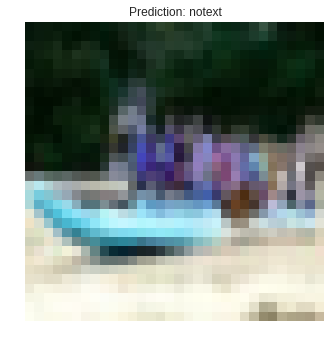

In [33]:
(text, notext) = model.predict(image)[0]
prediction = "text" if text > notext else "notext"

plt.title("Prediction: " + prediction)
plt.imshow(orig)
plt.axis('off')
plt.show()